## Exercise 1

### Task 1.1

In [382]:
import control as ctrl

R = 10
C = 1e-6
L = 4e-6

numerator = [L, 0]
denominator = [R*L*C, L, R]

G_s = ctrl.TransferFunction(numerator, denominator)

print(G_s)

<TransferFunction>: sys[232]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


        4e-06 s
------------------------
4e-11 s^2 + 4e-06 s + 10



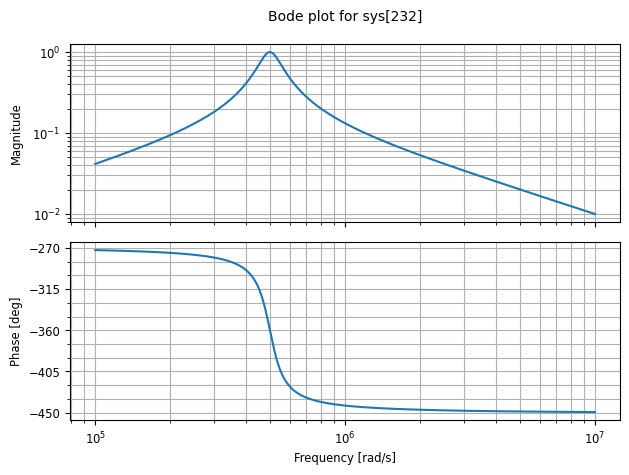

In [383]:
ctrl.bode(G_s)

In [384]:
import numpy as np
import matplotlib.pyplot as plt

'''
Simulink nie używa dyskretnych próbek, tylko solver w czasie ciągłym, który może:

Interpolować sygnał między punktami

Wprowadzać pewną „energię” w postaci pośredniej wartości, mimo że impuls trwa tylko chwilę

Zamiast symulować "czas ciągły", robisz bardzo gęstą siatkę czasową np. krok 
Wtedy system zachowuje się prawie jak ciągły.
'''

fmax = 1e7 / (2*np.pi)
fs = fmax * 4
dt = 1 / fs
step_time = dt

t = np.arange(0, 5e-4, dt)

u = np.ones_like(t)
u[t >= step_time] = 0

Ze wzgledu na bardziej realistyczne z punktu widzenia rzeczywistego układu podejscie zdecydowano sie na generowanie sygnału impulsowego o czasie trwania równym 2 * dt, zamiast tylko dt. W praktyce nie da się wygenerować idealnego impulsu Diraca, dlatego wykorzystuje się impulsy prostokątne o bardzo krótkim czasie trwania.

Zwiększenie szerokości impulsu poprawia jakość uzyskanej transformacji Fouriera – sygnał zawiera więcej energii, co skutkuje stabilniejszym widmem odpowiedzi oraz lepszym stosunkiem sygnału do szumu. Dzięki temu empirycznie wyznaczony wykres Bodego zachowuje bardzo dobrą zgodność z modelem teoretycznym.

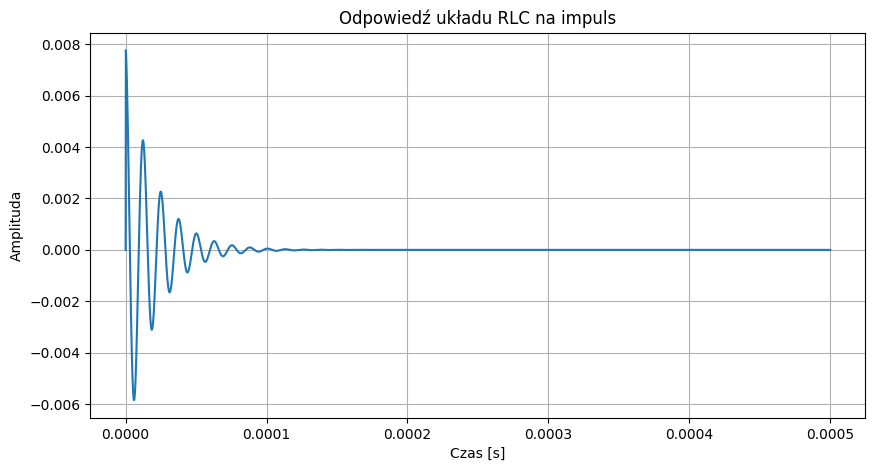

In [385]:
t_out, y_impulse = ctrl.forced_response(G_s, T=t, U=u)
plt.figure(figsize=(10, 5))
plt.plot(t_out, y_impulse)

plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Odpowiedź układu RLC na impuls')
plt.grid()

plt.show()

### Task 1.2

In [386]:
from scipy.fft import fft

N = len(t_out)
df = fs / N 
fv = np.arange(0, N) * df

X = fft(u)[:N//2]
Y = fft(y_impulse)[:N//2]
omega = 2 * np.pi * fv[:N//2]  # [rad/s]

H = (Y / X)
H_amp_db = 20 * np.log10(np.abs(H))
H_phase_deg = np.angle(H, deg=True)

In [387]:
mag, phase, omega_model = ctrl.bode(G_s, omega, plot=False)
H_model_amp_db = 20 * np.log10(mag.flatten())
H_model_phase_deg = phase * (180 / np.pi)

c:\Users\miki0\Desktop\Projects\model_ident\myenv\lib\site-packages\control\freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
C:\Users\miki0\AppData\Local\Temp\ipykernel_2456\2462089604.py:2: RuntimeWarning: divide by zero encountered in log10
  H_model_amp_db = 20 * np.log10(mag.flatten())


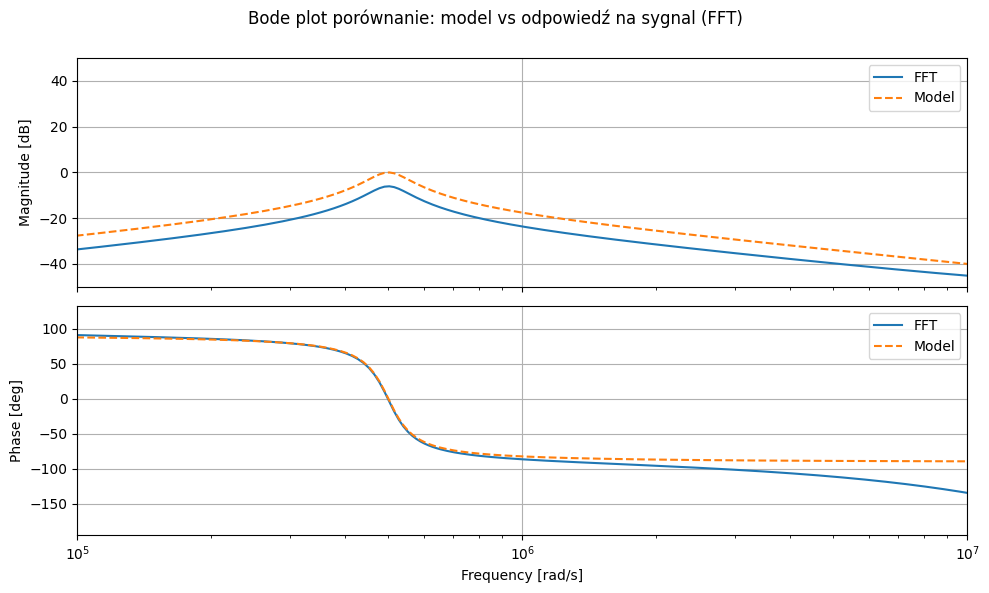

In [388]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].semilogx(omega, H_amp_db, label='FFT')
axes[0].semilogx(omega_model, H_model_amp_db, '--', label='Model')
axes[0].set_ylabel("Magnitude [dB]")
axes[0].set_xlim((1e5, 1e7))
axes[0].set_ylim((-50, 50))
axes[0].grid()
axes[0].legend()

axes[1].semilogx(omega, H_phase_deg, label='FFT')
axes[1].semilogx(omega_model, H_model_phase_deg, '--', label='Model')
axes[1].set_xlabel("Frequency [rad/s]")
axes[1].set_ylabel("Phase [deg]")
axes[1].set_xlim((1e5, 1e7))
axes[1].grid()
axes[1].legend()

fig.suptitle("Bode plot porównanie: model vs odpowiedź na sygnal (FFT)")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


Różnice między wykresem analitycznym (bode()) a tym z FFT wynikają z tego, że bode() oblicza idealną odpowiedź układu w dziedzinie częstotliwości, natomiast transformata Fouriera działa na sygnale rzeczywistym (dyskretnym, ograniczonym czasowo), który nie odwzorowuje idealnego impulsu Diraca. Dlatego odpowiedź empiryczna może mieć drobne odchylenia, zwłaszcza w zakresie amplitudy.

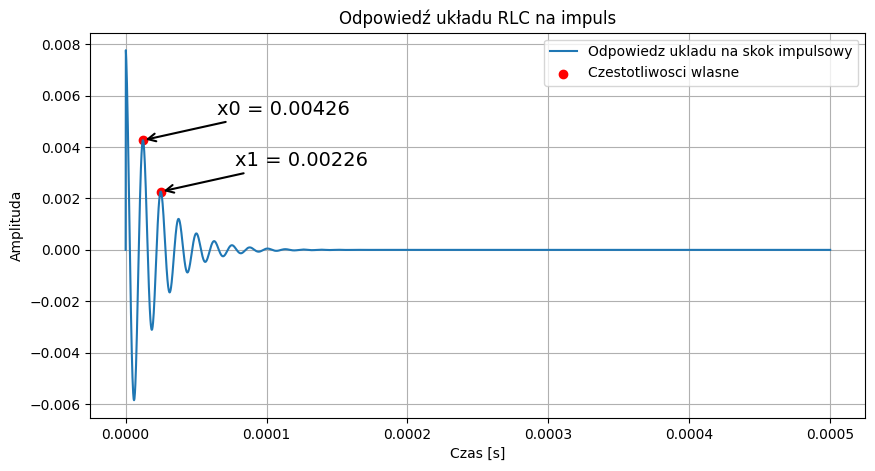

In [389]:
from scipy.signal import find_peaks

t_out, y = ctrl.forced_response(G_s, T=t, U=u)
peaks, _ = find_peaks(y, height=0.001)

plt.figure(figsize=(10, 5))

plt.plot(t_out, y, label='Odpowiedz ukladu na skok impulsowy')
plt.scatter([t_out[peaks[1]], t_out[peaks[2]]], [y[peaks[1]], y[peaks[2]]], c='r', label='Czestotliwosci wlasne')
for i, peak in enumerate(peaks[1:3]):
    plt.annotate(f'x{i} = {y[peak]:.5f}',
                 xy=(t_out[peak], y[peak]),
                 xytext=(t_out[peak] + 0.0001, y[peak] + 0.001),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
                 fontsize=14,
                 ha='center')
    
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Odpowiedź układu RLC na impuls')
plt.legend()
plt.grid()

plt.show()

In [390]:
x_0 = y[peaks[1]]
x_1 = y[peaks[2]]

epsilon = np.log(x_0/x_1) / (2*np.pi)
epsilon

np.float64(0.10057701981833589)

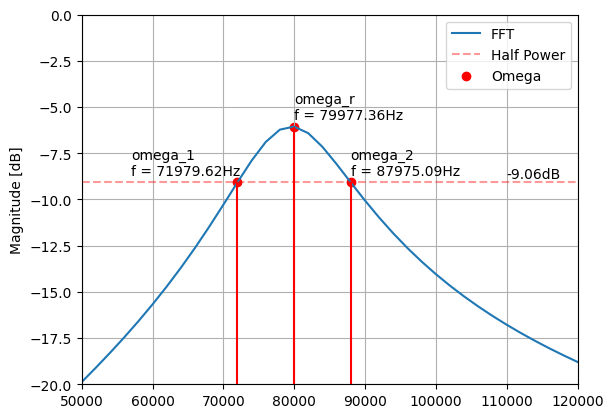

In [391]:
omega_hz = omega / (2*np.pi)

idx_max = np.argmax(H_amp_db)
half_power = H_amp_db.max() - 3

indices = np.where(H_amp_db <= half_power)[0]
omega_1_idx = indices[indices < idx_max][-1]
omega_2_idx = indices[indices > idx_max][0]

omega_r = omega_hz[idx_max]
omega_1 = omega_hz[omega_1_idx]
omega_2 = omega_hz[omega_2_idx]

plt.plot(omega_hz, H_amp_db, label='FFT')
plt.hlines(half_power, 5e4, 12e4, colors='r', linestyles='--', label='Half Power', alpha=0.4)
plt.scatter([omega_r, omega_1, omega_2], [H_amp_db[idx_max], H_amp_db[omega_1_idx], H_amp_db[omega_2_idx]], c='r', label='Omega')
plt.vlines([omega_r, omega_1, omega_2], -20, [H_amp_db[idx_max], H_amp_db[omega_1_idx], H_amp_db[omega_2_idx]], colors='r')
    
plt.text(11e4, half_power+0.2, f'{half_power:.2f}dB')
plt.text(omega_r, H_amp_db[idx_max]+0.4, f'omega_r\nf = {omega_r:.2f}Hz')
plt.text(omega_1-1.5e4, H_amp_db[omega_1_idx]+0.4, f'omega_1\nf = {omega_1:.2f}Hz')
plt.text(omega_2, H_amp_db[omega_2_idx]+0.4, f'omega_2\nf = {omega_2:.2f}Hz')

plt.ylabel("Magnitude [dB]")
plt.xlim((5e4, 12e4))
plt.ylim((-20, 0))
plt.grid()
plt.legend()

In [392]:
epsilon = (omega_2-omega_1) / (2*omega_r)
epsilon

np.float64(0.10000000000000014)

### Task 1.3

### R = 5 Ohm

In [393]:
R = 5
C = 1e-6
L = 4e-6

numerator = [L, 0]
denominator = [R*L*C, L, R]

G_s_5 = ctrl.TransferFunction(numerator, denominator)

print(G_s_5)

<TransferFunction>: sys[237]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


        4e-06 s
-----------------------
2e-11 s^2 + 4e-06 s + 5



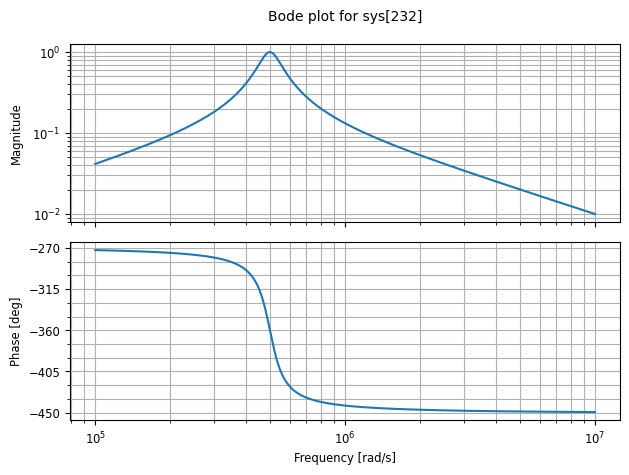

In [394]:
ctrl.bode(G_s)

In [395]:
fmax = 1e7 / (2*np.pi)
fs = fmax * 4
dt = 1 / fs
step_time = dt

t = np.arange(0, 5e-4, dt)

u = np.ones_like(t)
u[t >= step_time] = 0

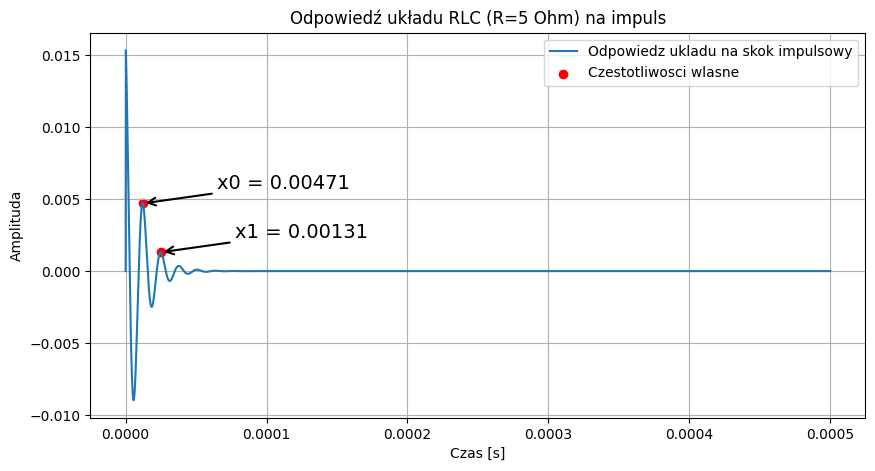

In [396]:
t_out, y_5 = ctrl.forced_response(G_s_5, T=t, U=u)
peaks, _ = find_peaks(y, height=0.001)

plt.figure(figsize=(10, 5))

plt.plot(t_out, y_5, label='Odpowiedz ukladu na skok impulsowy')
plt.scatter([t_out[peaks[1]], t_out[peaks[2]]], [y_5[peaks[1]], y_5[peaks[2]]], c='r', label='Czestotliwosci wlasne')
for i, peak in enumerate(peaks[1:3]):
    plt.annotate(f'x{i} = {y_5[peak]:.5f}',
                 xy=(t_out[peak], y_5[peak]),
                 xytext=(t_out[peak] + 0.0001, y_5[peak] + 0.001),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
                 fontsize=14,
                 ha='center')
    
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Odpowiedź układu RLC (R=5 Ohm) na impuls')
plt.legend()
plt.grid()

plt.show()

In [397]:
x_0 = y_5[peaks[1]]
x_1 = y_5[peaks[2]]

epsilon = np.log(x_0/x_1) / (2*np.pi)
epsilon

np.float64(0.2035421390314386)

### R = 100 Ohm

In [398]:
R = 100
C = 1e-6
L = 4e-6

numerator = [L, 0]
denominator = [R*L*C, L, R]

G_s_100 = ctrl.TransferFunction(numerator, denominator)

print(G_s_100)

<TransferFunction>: sys[240]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         4e-06 s
-------------------------
4e-10 s^2 + 4e-06 s + 100



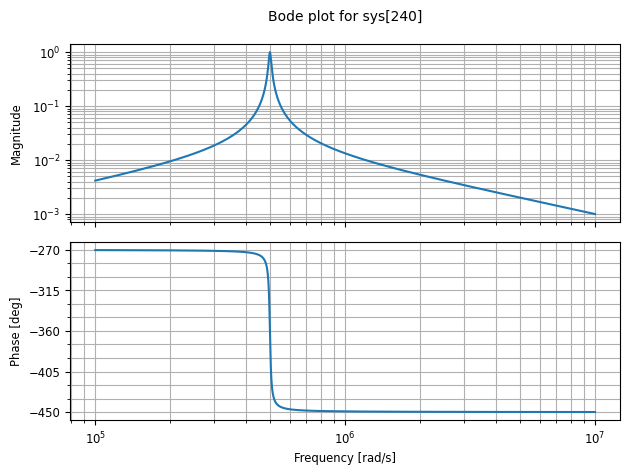

In [399]:
ctrl.bode(G_s_100)

In [400]:
fmax = 1e7 / (2*np.pi)
fs = fmax * 4
dt = 1 / fs
step_time = dt

t = np.arange(0, 5e-4, dt)

u = np.ones_like(t)
u[t >= step_time] = 0

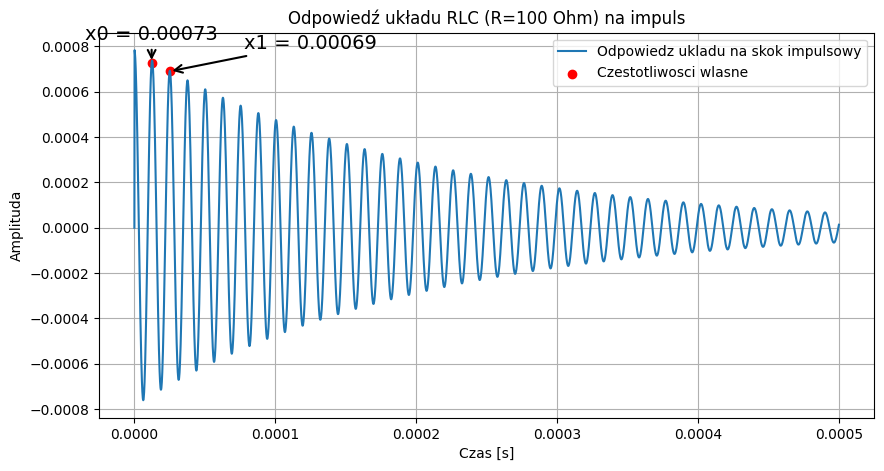

In [401]:
t_out, y_100 = ctrl.forced_response(G_s_100, T=t, U=u)
peaks, _ = find_peaks(y, height=0.001)

plt.figure(figsize=(10, 5))

plt.plot(t_out, y_100, label='Odpowiedz ukladu na skok impulsowy')
plt.scatter([t_out[peaks[1]], t_out[peaks[2]]], [y_100[peaks[1]], y_100[peaks[2]]], c='r', label='Czestotliwosci wlasne')
for i, peak in enumerate(peaks[1:3]):
    plt.annotate(f'x{i} = {y_100[peak]:.5f}',
                 xy=(t_out[peak], y_100[peak]),
                 xytext=(t_out[peak] + 0.0001*i, y_100[peak] + 0.0001),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
                 fontsize=14,
                 ha='center')
    
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Odpowiedź układu RLC (R=100 Ohm) na impuls')
plt.legend()
plt.grid()

plt.show()

In [402]:
x_0 = y_100[peaks[1]]
x_1 = y_100[peaks[2]]

epsilon = np.log(x_0/x_1) / (2*np.pi)
epsilon

np.float64(0.008440066696644849)

### Tlumienie krytyczne dla przyblizonej wartosci R

In [403]:
R = 0.1
C = 1e-6
L = 4e-6

numerator = [L, 0]
denominator = [R*L*C, L, R]

G_s_crit = ctrl.TransferFunction(numerator, denominator)

print(G_s_crit)

<TransferFunction>: sys[243]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         4e-06 s
-------------------------
4e-13 s^2 + 4e-06 s + 0.1



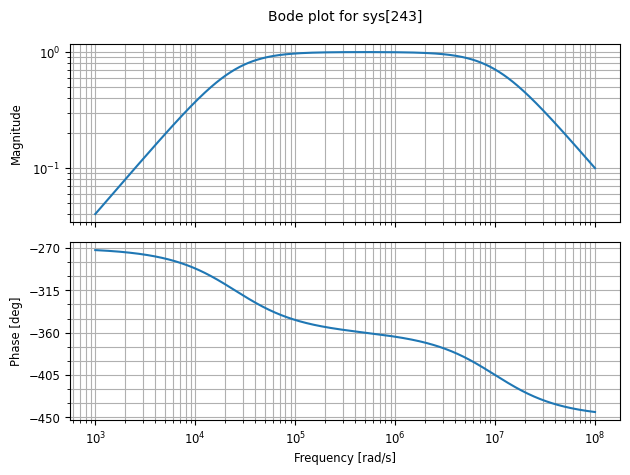

In [404]:
ctrl.bode(G_s_crit)

In [405]:
fmax = 1e8 / (2*np.pi)
fs = fmax * 4
dt = 1 / fs
step_time = dt

t = np.arange(0, 5e-4, dt)

u = np.ones_like(t)
u[t >= step_time] = 0

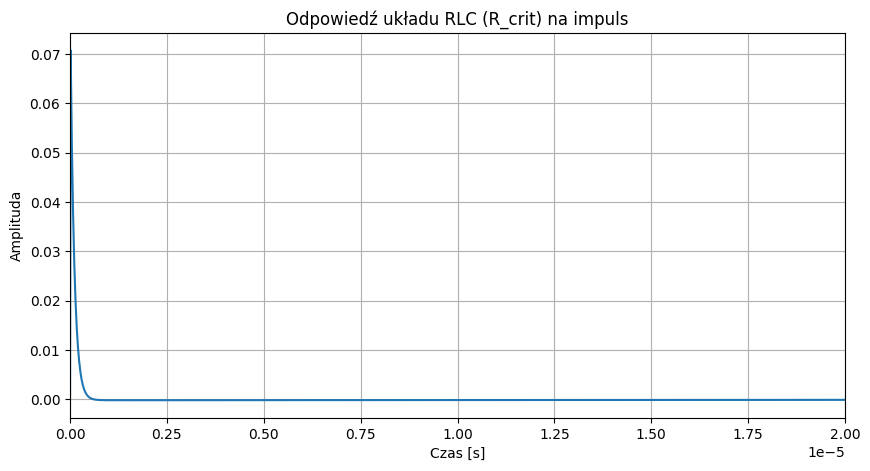

In [406]:
t_out, y_crit = ctrl.forced_response(G_s_crit, T=t, U=u)

plt.figure(figsize=(10, 5))

plt.plot(t_out, y_crit, label='Odpowiedz ukladu na skok impulsowy')

plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.xlim(0, 20e-6)
plt.title('Odpowiedź układu RLC (R_crit) na impuls')
plt.grid()

plt.show()

In [407]:
peaks, _ = find_peaks(y, height=0.001)

x_0 = y_crit[peaks[1]]
x_1 = y_crit[peaks[2]]

epsilon = np.log(x_0/x_1) / (2*np.pi)
epsilon

np.float64(0.0047358367696841265)

## Exercsie 2

### Task 2.1

In [408]:
R = 10
C = 1e-6
L = 4e-6

numerator = [L, 0]
denominator = [R*L*C, L, R]

G_s = ctrl.TransferFunction(numerator, denominator)

print(G_s)

<TransferFunction>: sys[246]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


        4e-06 s
------------------------
4e-11 s^2 + 4e-06 s + 10



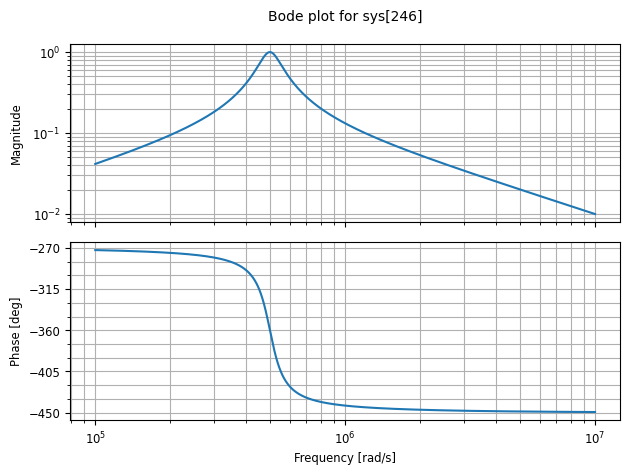

In [409]:
ctrl.bode(G_s)

In [410]:
# Sinus params
A_sin = 1
f_sin = [70e3, 80e3, 90e3]
T_sin = [1 / f for f in f_sin]

# Simulation params
f_max = 1e7 / (2*np.pi)
fs = f_max * 40
dt = 1 / fs

In [411]:
def plot_lines(x_points, y_points, line):
    if line == 'vertical':
        plt.vlines(x_points[0], y_points[0], y_points[1])
        plt.vlines(x_points[1], y_points[0], y_points[1])
        
        plt.annotate('',
                     xy=(x_points[0], y_points[1]),
                     xytext=(x_points[0] + 0.0002, y_points[1]),
                     arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5))
        plt.text(x_points[1] + 3e-5, y_points[1] + 0.03, f'Przesuniecie w czasie: {(x_points[0] - x_points[1]):.9f}s')

    else:
        plt.hlines(y_points[0], x_points[0], x_points[1])
        plt.hlines(y_points[1], x_points[0], x_points[1])

        y_middle = (y_points[0] + y_points[1]) / 2
        plt.annotate('', xy=(x_points[1], y_points[0]), xytext=(x_points[1], y_points[1]),
                     arrowprops=dict(facecolor='black', arrowstyle='<->', lw=1.5))
        plt.text(x_points[1] - 0.00001, y_middle, f'2x Amplituda: {abs(y_points[1] - y_points[0]):.4f}', rotation=90, va='center')

Przesunięcie fazowe eksperymentalne (f = 70000.0Hz): 52.25 stopni


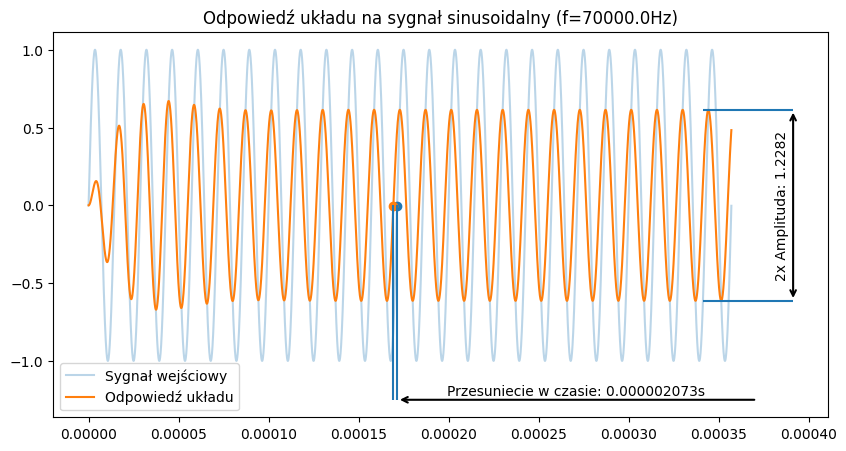

Przesunięcie fazowe eksperymentalne (f = 80000.0Hz): -2.71 stopni


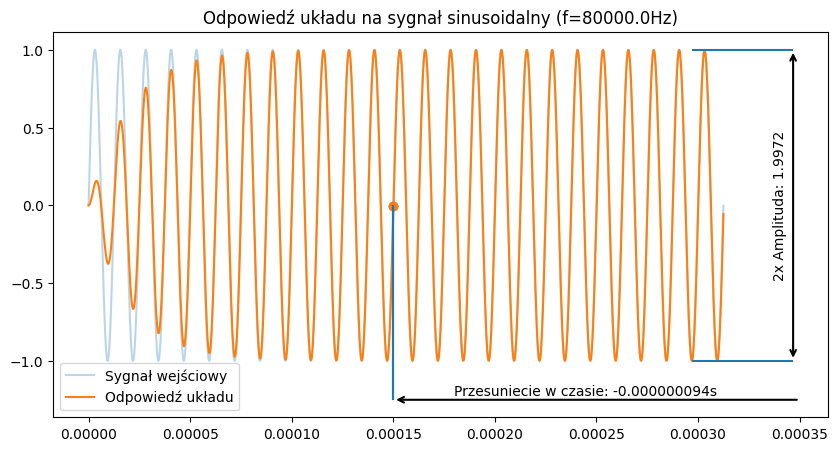

Przesunięcie fazowe eksperymentalne (f = 90000.0Hz): -50.89 stopni


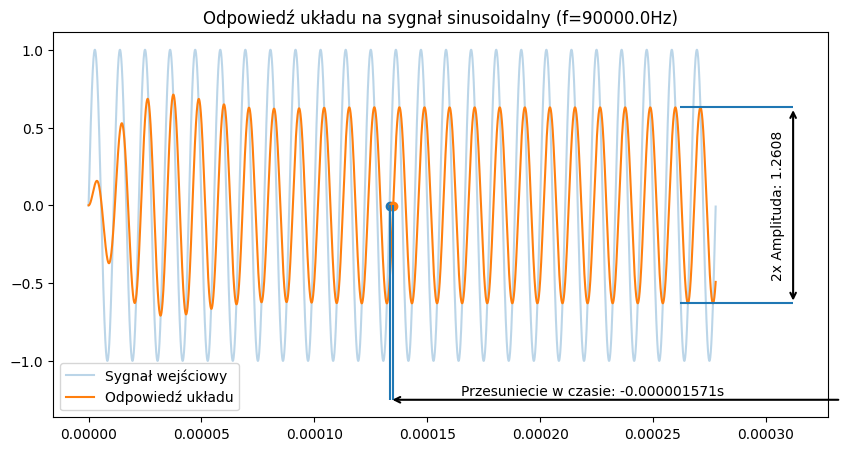

In [412]:
for i in range(len(f_sin)):
    plt.figure(figsize=(10, 5))

    t = np.arange(0, 25 * T_sin[i], dt)
    u_sin = A_sin * np.sin(2*np.pi*f_sin[i]*t)
    t_out, y = ctrl.forced_response(G_s, T=t, U=u_sin)

    plt.plot(t, u_sin, alpha=0.3, label='Sygnał wejściowy')
    plt.plot(t_out, y, label='Odpowiedź układu')

    # Steady State
    steady_state_idx = round(10 * T_sin[i] * fs)

    # Output amplitude
    y_max = y[steady_state_idx:].max()
    y_min = y[steady_state_idx:].min()
    amp_out = (y_max - y_min) / 2
    plot_lines([t_out[-1000], t_out[-1000] + 0.00005], [y_min, y_max], line='horizontal')

    # Phase Shift
    u_zero_mask = np.where((u_sin[:-1] < 0) & (u_sin[1:] >= 0))[0]    # Signal u goes thorugh 0
    u_zero_mask = u_zero_mask[steady_state_idx + 1000 < u_zero_mask]  # Indexes of u_zero_mask after steady state
                                                                      # A value of 1000 was added to the steady state index to ensure that the 
                                                                      # first samples do not pass through 0
    y_zero_mask = np.where((y[:-1] < 0) & (y[1:] >= 0))[0]
    y_zero_mask = y_zero_mask[steady_state_idx + 1000 < y_zero_mask]

    t_u_zero = t[u_zero_mask[0]]
    t_y_zero = t[y_zero_mask[0]]
    plt.scatter(t_u_zero, u_sin[u_zero_mask[0]])
    plt.scatter(t_y_zero, y[y_zero_mask[0]])
    plot_lines([t_u_zero, t_y_zero], [0, -1.25], line='vertical')
    
    dt_shift = t_u_zero - t_y_zero
    phase_shift = 360 * (dt_shift/T_sin[i])
    print(f'Przesunięcie fazowe eksperymentalne (f = {f_sin[i]}Hz): {phase_shift:.2f} stopni')

    plt.legend()
    plt.title(f'Odpowiedź układu na sygnał sinusoidalny (f={f_sin[i]}Hz)')
    plt.show()


### Task 2.1

In [413]:
import control as ctrl

R = 10
C = 1e-6
L = 4e-6

numerator = [L, 0]
denominator = [R*L*C, L, R]

G_s = ctrl.TransferFunction(numerator, denominator)

print(G_s)

<TransferFunction>: sys[251]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


        4e-06 s
------------------------
4e-11 s^2 + 4e-06 s + 10



In [414]:
fmax = 1e7 / (2*np.pi)
fs = fmax * 40
dt = 1 / fs
step_time = dt

A_sin = 1
f_sin = 70e3
T = 1 / f_sin
t = np.arange(0, 5e-4, dt)
u_sin = A_sin * np.sin(2*np.pi*f_sin*t)

u = np.ones_like(t)
u[t >= step_time] = 0

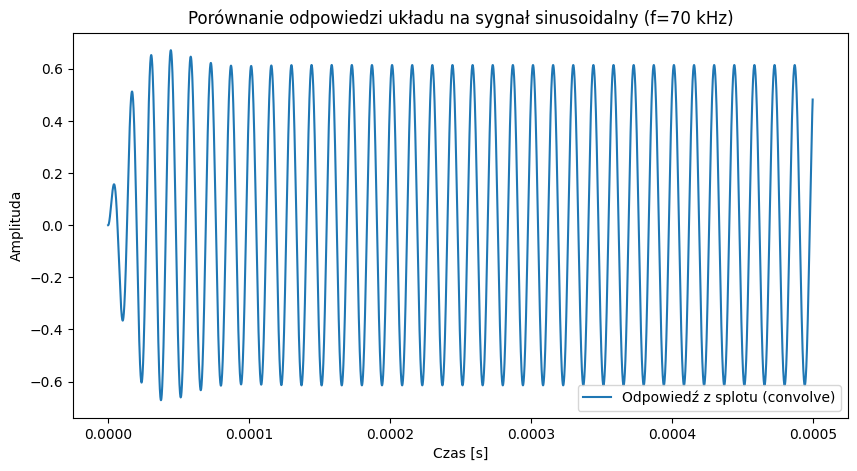

In [415]:
from scipy.signal import convolve

t_out, y_impulse = ctrl.impulse_response(G_s, T=t)

y_conv = convolve(u_sin, y_impulse) * dt  # Wynik splotu
t_conv = np.arange(0, len(y_conv)) * dt  # Odpowiedni wektor czasu dla splotu

# Dopasowanie rozmiaru czasów
t_conv = t_conv[:len(t_out)]
y_conv = y_conv[:len(t_out)]

# Wykres odpowiedzi skokowej i odpowiedzi z splotu
plt.figure(figsize=(10, 5))
# plt.plot(t_out, y_impulse, label='Odpowiedź impulsowa (impulse_response)')
plt.plot(t_conv, y_conv, label='Odpowiedź z splotu (convolve)')
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Porównanie odpowiedzi układu na sygnał sinusoidalny (f=70 kHz)')
plt.legend()
plt.show()